In [1]:
using Pkg
Pkg.activate(".")
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using MultivariateStats
using NNlib
using Discretizers
using EvalMetrics
FIG_DIR = "./"
PLT_CELL = 500
Nq = 500
epfrac = 0.1

include("comparisons/process_outputs_util.jl")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated`


process_genie3 (generic function with 1 method)

In [56]:
FIG_DIR="/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/"

"/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/"

In [3]:
DATA_PATH="../../data/simulated/Synthetic_1000/dyn-SW/dyn-SW-1000-2/"
cd(DATA_PATH)

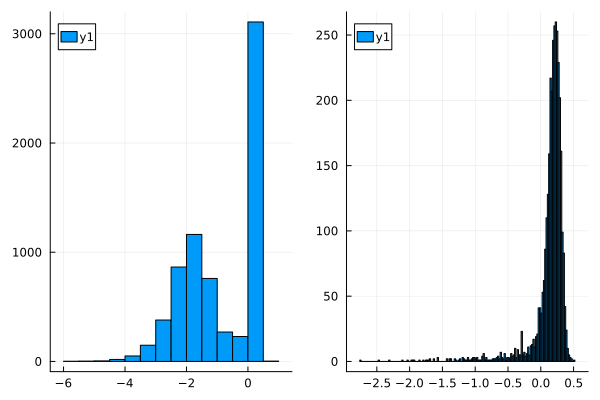

In [4]:
X_raw = npzread("X.npy")
X = relu.(X_raw .- 10^(-0.5));
plot(histogram(log10.(vec(X_raw))), 
    histogram(log10.(vec(X))))

In [5]:
Ng = size(X, 2)
rm_diag(A) = A - Diagonal(diag(A))
preprocess_cespgrn(x) = hcat([vec(rm_diag(reshape(x, Ng, Ng))) for x in eachrow(x)]...)'

preprocess_cespgrn (generic function with 1 method)

In [6]:
X_pca = npzread("X_pca.npy")
X_umap = npzread("X_pca.npy")
P = npzread("P_velo_dot.npy")
J = permutedims(npzread("J.npy"), [1, 3, 2])
C = npzread("C.npy")
dpt = npzread("dpt.npy");

In [7]:
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));

In [8]:
gene_idxs = vcat([[j, i]' for i = 1:size(X, 2) for j = 1:size(X, 2)]...);

In [9]:
k = 3
Q = locaTE.to_backward_kernel(P);
R_sp = sparse(R)
QT_sp = sparse((Q^k)')
P_sp = sparse((P^k));

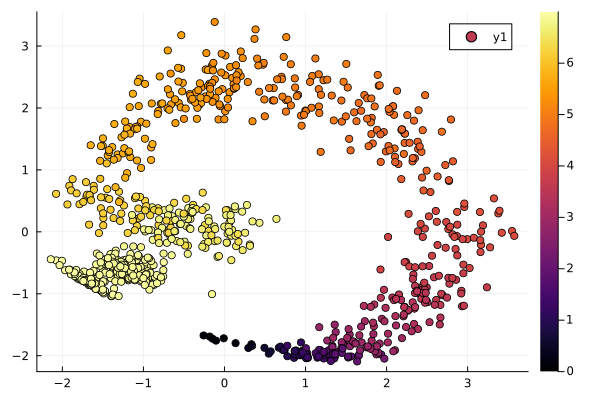

In [10]:
scatter(X_umap[:, 1], X_umap[:, 2], marker_z = log1p.(C[sortperm(dpt)[1], :]))

In [11]:
scatter(X_umap[:, 1], X_umap[:, 2], marker_z = dpt, c = :viridis, legend = nothing, colorbar = nothing, markerstrokewidth = 0, xlabel = "PCA1", ylabel = "PCA2", size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_pca.pdf"))

"/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/switch_pca.pdf"

In [12]:
heatmap((R * P * R)[sortperm(dpt), :][:, sortperm(dpt)], 
    clim = (0, quantile(vec(P[P .> 0]), 0.5)), c = :viridis, colorbar = nothing, size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_P.pdf"))

"/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/switch_P.pdf"

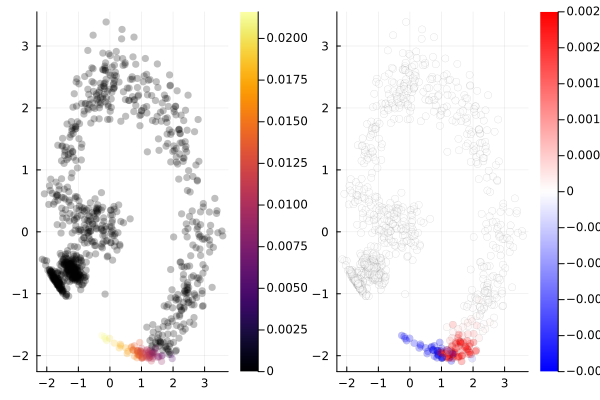

In [13]:
p0 = R[sortperm(dpt)[1], :]
plot(scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = p0, markerstrokewidth = 0, alpha = 0.25), 
    scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = P_sp'*p0 - p0, color = :bwr, clim = (-0.0025, 0.0025), markerstrokewidth = 0.25, alpha = 0.25); legend = nothing)

In [14]:
L = locaTE.construct_normalized_laplacian(X_pca, 25);
TE = estimate_TE(X, 1:size(X, 2), 1:size(X, 2), P_sp, QT_sp, R_sp; showprogress = true, wclr = false);
TE_clr = apply_wclr(TE, size(X, 2)); TE_clr[isnan.(TE_clr)] .= 0;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [15]:
w = normalize(vec(sqrt.(sum(TE_clr.^2; dims = 2))), 1)
G = fitsp(TE_clr, L; λ1 = 25.0, λ2 = 0.001, maxiter = 250);
G_symm = locaTE.symm_row(G, size(X, 2));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: ΔX = 1.1152709031390652e-7, ΔZ = 1.6661773671211577e-5, ΔW = 5.2596262461190174e-5
[ Info: tr(X'LX) = 0.17191755496866934, 0.5|X-G|^2 = 1.3955137592417128, |X|1 = 313.52131337871646


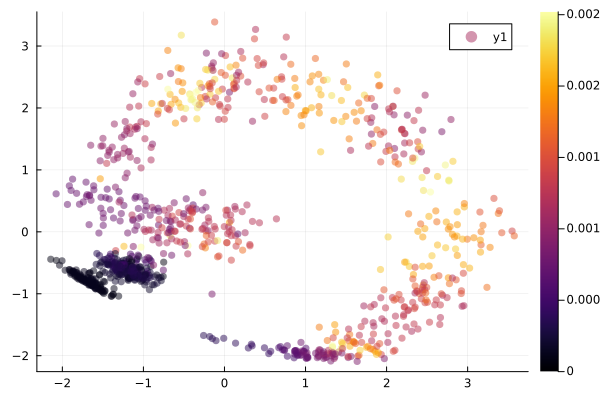

In [16]:
# TE density 
scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = w, markerstrokewidth = 0, clim = (0, quantile(w, 0.995)), alpha = 0.5)

In [17]:
A = reshape(maximum(G; dims = 1), size(X, 2), size(X, 2))
G_cdf = apply_cdf_norm(G, A .+ 1e-9);
G_static = reshape(mean(G; dims = 1), size(X, 2), size(X, 2));
G_static_cdf = locaTE.cdf_norm(G_static, G_static .+ 1e-9);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


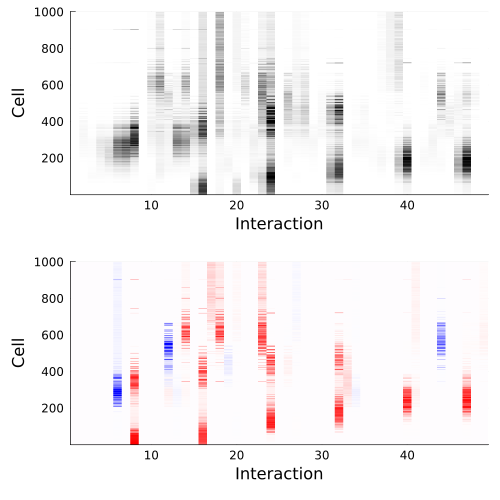

In [18]:
plt=plot(heatmap(G[sortperm(dpt), :]; xlabel = "Interaction", ylabel = "Cell", c = cgrad([:white, :black]), clim = (0, quantile(vec(G), 0.995))), 
    heatmap((R * reshape(J, :, size(X, 2)^2))[sortperm(dpt), :], c = :bwr, clim = (-1.5, 1.5); xlabel = "Interaction", ylabel = "Cell"),
    colorbar = nothing, layout = (2, 1), size = (PLT_CELL,PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_network_matrix.svg"))
plt

In [19]:
id = npzread("clusterid.npy");

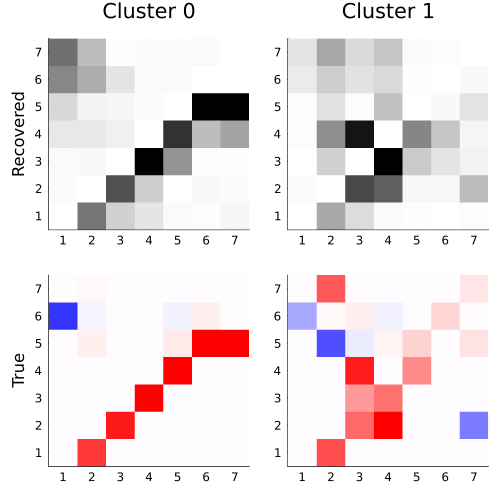

In [20]:
plt1=plot([heatmap(normalize(reshape(mean(G[id .== i, :]; dims = 1), size(X, 2), size(X, 2)), Inf), c = cgrad([:white,  :black]), title = "Cluster $i", clim = (0, 0.9), ylabel = i == 0 ? "Recovered" : "") for i in sort(unique(id))]...; layout = (1, 2), colorbar = nothing)
plt2=plot([heatmap(normalize(mean(J[id .== i, :, :]; dims = 1)[1, :, :], Inf); c = :bwr, clim = (-0.9, 0.9), ylabel = i == 0 ? "True" : "") for i in sort(unique(id))]...; layout = (1, 2), colorbar = nothing)
plt=plot(plt1, plt2; layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_network_cluster_averages.pdf"))
plt

In [21]:
using Colors

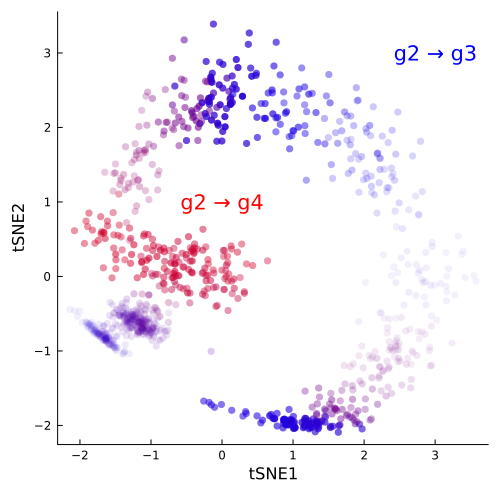

In [22]:
interactions = hcat([reshape(G, :, size(X, 2), size(X, 2))[:, x] for x in [CartesianIndex(2, 3), CartesianIndex(2, 4)]]...)
interactions_norm = interactions ./ sum(interactions; dims = 2)
interactions_norm[isnan.(interactions_norm)] .= 0
plt=scatter(X_umap[:, 1], X_umap[:, 2], markerstrokewidth = 0, c = sum([colorant"blue", colorant"red"]' .* interactions_norm; dims = 2), alpha = normalize(sum(interactions; dims = 2), Inf), legend = nothing,
        size = (PLT_CELL, PLT_CELL), grid = false, xlabel = "tSNE1", ylabel = "tSNE2")
annotate!(3, 3, text("g2 → g3", colorant"blue"))
annotate!(0, 1, text("g2 → g4", colorant"red"))
savefig(string(FIG_DIR, "switch_sim_diff_reg.pdf"))
plt

In [23]:
J_symm = permutedims(cat([locaTE.symm(x) for x in eachslice(abs.(J); dims = 1)]...; dims = 3), [3, 1, 2])
J_static = (mean(abs.(J); dims = 1)[1, :, :] .> 0.1)*1.0
J_static_symm = locaTE.symm(J_static);
J_thresh = 0.5

0.5

In [24]:
using DataFrames
using CSV
using Glob

# TENET
DIR_COMPARISON = "tenet/"
tenet_paths = Glob.glob("A_tenet_k*.txt", DIR_COMPARISON)
tenet_results = map(x -> process_tenet(x, J_static), tenet_paths);
G_tenet = first(tenet_results[argmax(map(last, tenet_results))]);

# SCODE
DIR_COMPARISON = "scode/"
scode_paths = Glob.glob("SCODE_D_4/A_rep_*.txt", DIR_COMPARISON)
scode_results = map(x -> process_scode(x, J_static), scode_paths)
G_scode = first(scode_results[argmax(map(last, scode_results))]);

# GRISLI
DIR_COMPARISON = "grisli/"
grisli_paths = Glob.glob("A_grisli_L_*.csv", DIR_COMPARISON)
grisli_results = map(x -> process_grisli(x, J_static), grisli_paths)
G_grisli = first(grisli_results[argmax(map(last, grisli_results))]);

# SINCERITIES
DIR_COMPARISON = "sincerities/"
sincerities_paths = Glob.glob("A.txt", DIR_COMPARISON)
sincerities_results = map(x -> process_sincerities(x, J_static), sincerities_paths)
G_sincerities = first(sincerities_results[argmax(map(last, sincerities_results))]);

# SCRIBE
DIR_COMPARISON = "scribe/"
scribe_path = string(DIR_COMPARISON, "G_scribe.npy");
scribe_results = process_scribe(scribe_path, J_static)
G_scribe = first(scribe_results);
G_scribe[isnan.(G_scribe)] .= 0;

# PIDC
G_pidc = Array(npzread("G_pidc.npy"));

# CeSpGRN
G_cespgrn = Array(abs.(preprocess_cespgrn(npzread("cespgrn_output_100_0.25_0.05/G_cespgrn.npy"))));

# GENIE3
G_genie3 = Array(CSV.read("genie3/A.csv", DataFrame)[:, 2:end]);

In [25]:
agg_fun = x -> mean(x; dims = 1)

#74 (generic function with 1 method)

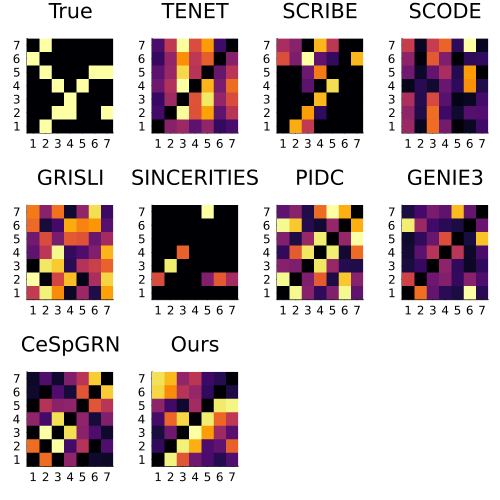

In [26]:
plot(heatmap(J_static, title = "True"), 
    heatmap(G_tenet, title = "TENET"), 
    heatmap(G_scribe, title = "SCRIBE"), 
    heatmap(G_scode, title = "SCODE"), 
    heatmap(G_grisli, title = "GRISLI"), 
    heatmap(G_sincerities, title = "SINCERITIES"), 
    heatmap(G_pidc, title = "PIDC"), 
    heatmap(G_genie3, title = "GENIE3"), 
    heatmap(reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), title = "CeSpGRN"), 
    heatmap(reshape(G_static_cdf, size(X, 2), size(X, 2)), title = "Ours"); 
    colorbar = nothing, size = (500, 500))

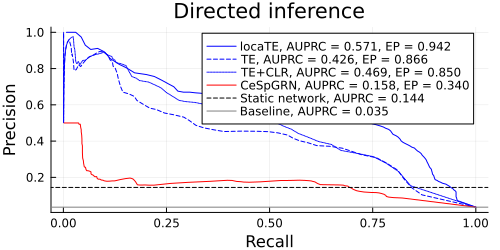

In [27]:
# AUPRC
plt1=plot(; title="Directed inference", size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision")
# locaTE
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G_cdf, Nq)))
plot!(r, p; label = @sprintf("locaTE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
# TE
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), TE, Nq)))
plot!(r, p; label = @sprintf("TE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dash)
# TE + CLR
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), TE_clr, Nq)))
plot!(r, p; label = @sprintf("TE+CLR, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dot)
# cespgrn (symmetric)
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G_cespgrn, Nq)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
# static baseline
baseline_static = aupr(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), repeat(reshape(J_static, 1, :), size(X, 1)), Nq))...)
hline!([baseline_static, ],
    label = @sprintf("Static network, AUPRC = %0.3f", baseline_static), 
    linestyle = :dash, color = :black)
# baseline 
baseline = mean((R * reshape(abs.(J), :, size(X, 2)^2)) .> 0.5)
hline!([baseline, ]; label = @sprintf("Baseline, AUPRC = %0.3f", baseline), color = :grey)

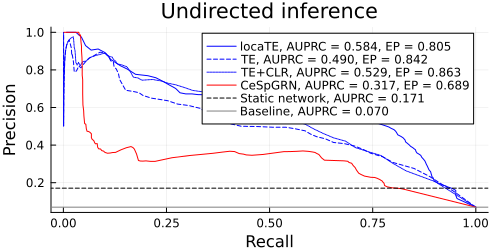

In [28]:
# ours
plt2=plot(; title = "Undirected inference", size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision")
# locaTE
p, r = collect(eachcol(prec_rec_rate(R * reshape(J_symm, :, size(X, 2)*size(X, 2)), locaTE.symm_row(G_cdf, size(X, 2)), Nq)))
plot!(r, p; label = @sprintf("locaTE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
# TE
p, r = collect(eachcol(prec_rec_rate(R * reshape(J_symm, :, size(X, 2)*size(X, 2)), locaTE.symm_row(TE, size(X, 2)), Nq)))
plot!(r, p; label = @sprintf("TE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dash)
# TE+CLR
p, r = collect(eachcol(prec_rec_rate(R * reshape(J_symm, :, size(X, 2)*size(X, 2)), locaTE.symm_row(TE_clr, size(X, 2)), Nq)))
plot!(r, p; label = @sprintf("TE+CLR, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dot)
# CeSpGRN
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J_symm), :, size(X, 2)*size(X, 2)), G_cespgrn, Nq)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
# static baseline
baseline_static = aupr(eachcol(prec_rec_rate(R * reshape(abs.(J_symm), :, size(X, 2)*size(X, 2)), repeat(reshape(J_static_symm, 1, :), size(X, 1)), Nq))...)
hline!([baseline_static, ],
    label = @sprintf("Static network, AUPRC = %0.3f", baseline_static),
    linestyle = :dash, color = :black,
    )
# baseline 
baseline = mean((R * reshape(abs.(J_symm), :, size(X, 2)^2)) .> 0.5)
hline!([baseline, ]; label = @sprintf("Baseline, AUPRC = %0.3f", baseline), color = :grey)

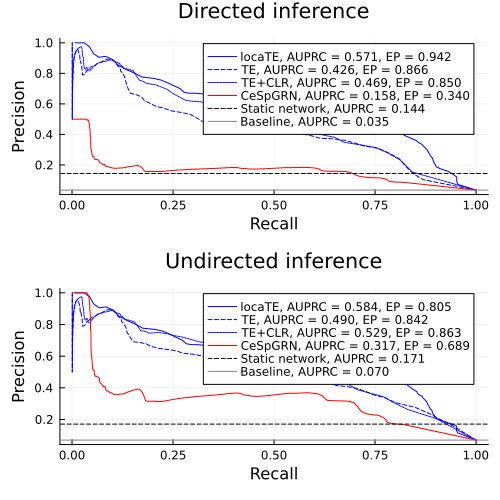

In [29]:
plt=plot(plt1, plt2; layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_pr.pdf"))
plt

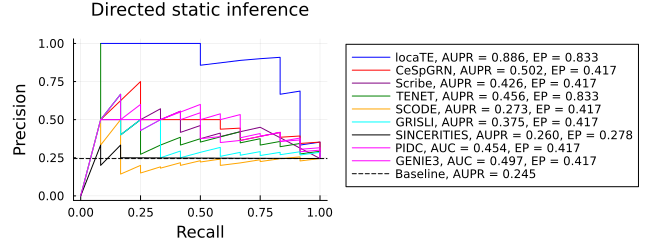

In [30]:
# static, directed
plt1=plot(; title = "Directed static inference", titlefontsize = 12, legend = :outertopright, size = (4/3*PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", margin = 5Plots.mm)
p, r = collect(eachcol(prec_rec_rate(J_static, G_static_cdf, 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_static, reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_static, G_scribe, 512)))
plot!(r, p; label = @sprintf("Scribe, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_static, G_tenet, 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_static, G_scode, 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :orange)
p, r = collect(eachcol(prec_rec_rate(J_static, G_grisli, 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :cyan)
p, r = collect(eachcol(prec_rec_rate(J_static, G_sincerities, 512)))
plot!(r, p; label = @sprintf("SINCERITIES, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :black)
p, r = collect(eachcol(prec_rec_rate(J_static, G_pidc, 512)))
plot!(r, p; label = @sprintf("PIDC, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J_static, G_genie3, 512)))
plot!(r, p; label = @sprintf("GENIE3, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
hline!([mean(J_static), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_static)), color = :black, linestyle = :dash)

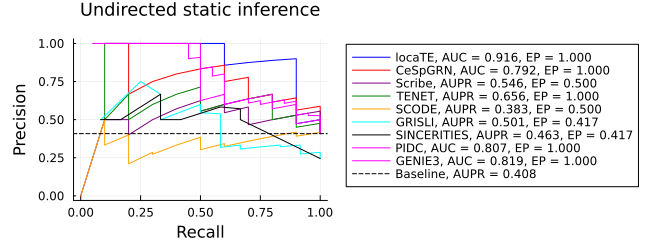

In [31]:
# static, undirected
plt2=plot(; title = "Undirected static inference", titlefontsize = 12, legend = :outertopright, size = (4/3*PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", margin = 5Plots.mm)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, locaTE.symm(G_static_cdf), 512)))
plot!(r, p; label = @sprintf("locaTE, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, locaTE.symm(G_scribe), 512)))
plot!(r, p; label = @sprintf("Scribe, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, locaTE.symm(G_tenet), 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, locaTE.symm(G_scode), 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :orange)
p, r = collect(eachcol(prec_rec_rate(J_static, locaTE.symm(G_grisli), 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :cyan)
p, r = collect(eachcol(prec_rec_rate(J_static, locaTE.symm(G_sincerities), 512)))
plot!(r, p; label = @sprintf("SINCERITIES, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :black)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, G_pidc, 512)))
plot!(r, p; label = @sprintf("PIDC, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, G_genie3, 512)))
plot!(r, p; label = @sprintf("GENIE3, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
hline!([mean(J_static_symm), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_static_symm)), color = :black, linestyle = :dash)

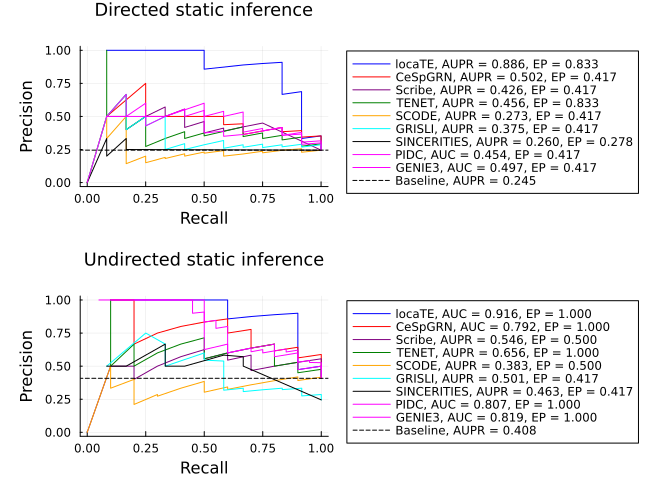

In [32]:
plt=plot(plt1, plt2; layout = (2, 1), size = (4/3*PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_pr_static.pdf"))
plt

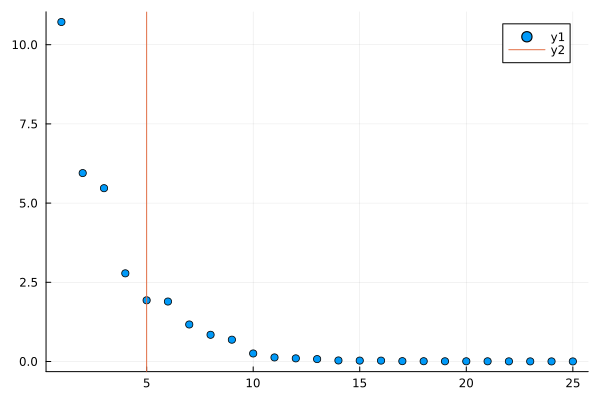

In [64]:
_, s, _ = svd(TE_clr); s.^=2
scatter(s[1:25])
svd_rank=findall((cumsum(s) .> 0.8*sum(s)))[1]
vline!([svd_rank, ])

In [65]:
using Suppressor

In [66]:
# now play with factor analysis
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0

U, V, trace =  fitnmf(relu.(qnorm(TE_clr, 0.9)),
                         [I(size(G, 1)), I(size(G, 2))], 1e-3*I + L,
                         repeat(vec(Cg), 1, size(X, 1))',
                         svd_rank;
                         α = 25.0,
                         β = 0.0, 
                  λ = [1.0, 1.0],
                  μ = [1.0, 1.0],
                  iter = 2_500, initialize = :nmf, print_iter = 100, dictionary = false, η = 1.0);
G_nmf = U*V';
# 
V .*= maximum(U; dims = 1)
U ./= maximum(U; dims = 1);
# 
A = reshape(maximum(V'; dims = 1), size(X, 2), size(X, 2))
for i = 1:size(V, 2)
    x = reshape(V[:, i], size(X, 2), size(X, 2))
    V[:, i] .= vec(cdf_norm(x, A .+ 1e-9))
end
npzwrite("U.npy", U)
npzwrite("V.npy", V)

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


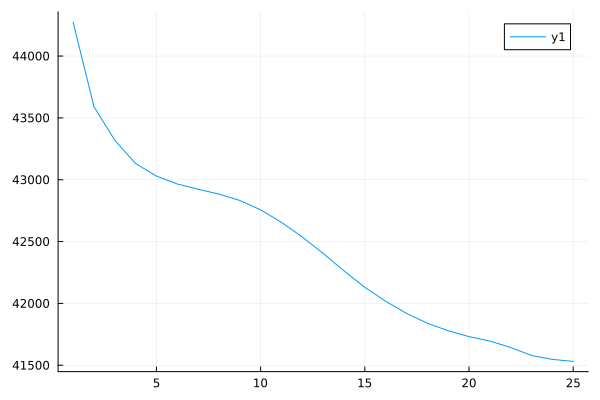

In [67]:
plot(trace)

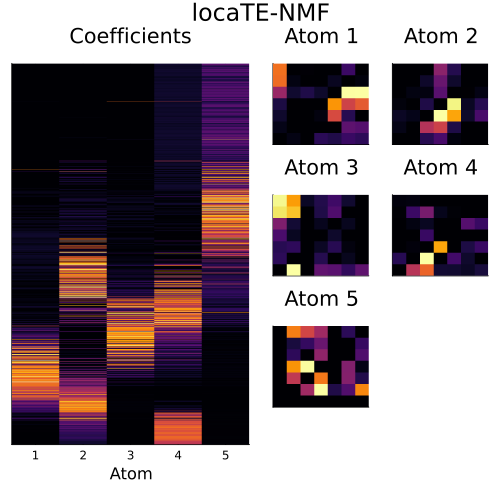

In [68]:
perm = sortperm(vec(sum((U ./ sum(U; dims = 1)) .* dpt; dims = 1)))
# sorted in order of activation
plt2=plot([heatmap(reshape(v, size(X, 2), size(X, 2)); title = "Atom $i", axis = nothing) for (i, v) in enumerate(eachcol(V[:, perm]))]...; colorbar = nothing, layout = (4, 2))
plt1=heatmap(U[sortperm(dpt), perm], colorbar = nothing, size = (PLT_CELL/2, PLT_CELL), yaxis = nothing, title = "Coefficients", xticks = (1:size(U, 2)), xlabel = "Atom")
plt=plot(plt1, plt2; size = (PLT_CELL, PLT_CELL), plot_title = "locaTE-NMF")
savefig(string(FIG_DIR, "switch_sim_nmf_components.pdf"))
plt

In [246]:
# NTF
using TensorToolbox
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
S, A, trace = fitntf(Array(reshape(qnorm(TE_clr, 0.9), :, size(X, 2), size(X, 2))),
                     [I(size(X, 1)), I(size(X, 2)), I(size(X, 2))], 1e-3*I + L, repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1)), 
                     [1, 1, 1],
                     [1, 1, 1],
                     25.0,
                     0.0,
                     8; iter = 500, dictionary = false, η = 1);

G_ntf = reshape(ttm(S, A, 1:length(A)), :, size(X, 2)^2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


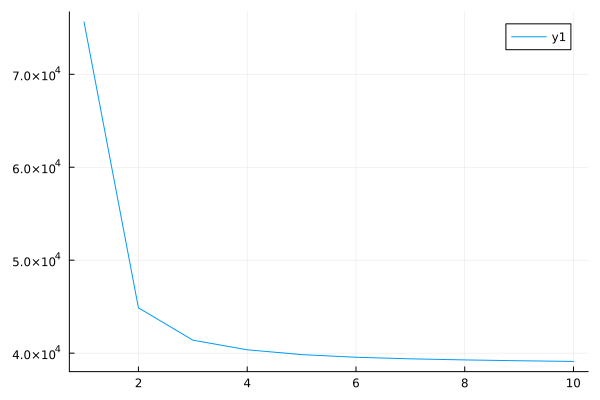

In [247]:
plot(trace)

In [248]:
ntf_atoms = [vec(x*y') for (x, y) in zip(eachcol(A[2]), eachcol(A[3]))];

In [249]:
U = A[1];
V = hcat(ntf_atoms...);

V .*= maximum(U; dims = 1)
U ./= maximum(U; dims = 1);
# 
A = reshape(maximum(V'; dims = 1), size(X, 2), size(X, 2))
for i = 1:size(V, 2)
    x = reshape(V[:, i], size(X, 2), size(X, 2))
    V[:, i] .= vec(cdf_norm(x, A .+ 1e-9))
end
npzwrite("U_ntf.npy", U)
npzwrite("V_ntf.npy", V)

In [ ]:
using Clustering
using StatsPlots
M = 1 .- cor(A[1])
M[isnan.(M)] .= 0
hc = hclust(M)
clusts = cutree(hc; k = 8)
ntf_atoms_clust_activity = hcat([sum(A[1][:, clusts .== i]; dims = 2) for i = 1:length(unique(clusts))]...)
ntf_atoms_clust = [sum(ntf_atoms[clusts .== i]) for i = 1:length(unique(clusts))];
ntf_atoms_clust_nums = [sum(clusts .== i) for i = 1:length(unique(clusts))];

In [ ]:
perm_clust = sortperm(vec(sum((ntf_atoms_clust_activity ./ sum(ntf_atoms_clust_activity; dims = 1)) .* dpt; dims = 1)))
perm = sortperm(vec(sum((A[1] ./ sum(A[1]; dims = 1)) .* dpt; dims = 1)))
# sorted in order of activation
plt2=plot([heatmap(x; title = "Cluster $(perm_clust[i]) ($(ntf_atoms_clust_nums[perm_clust[i]]))", axis = nothing, titlefontsize = 12) for (i, x) in enumerate(ntf_atoms_clust[perm_clust])]...; colorbar = nothing, layout = (4, 2))
plt1=heatmap(A[1][sortperm(dpt), perm], colorbar = nothing, size = (PLT_CELL/2, PLT_CELL), yaxis = nothing, title = "Coefficients", xticks = (1:size(A[1], 2), clusts[perm]), xlabel = "Cluster")
plt=plot(plt1, plt2; size = (PLT_CELL, PLT_CELL), plot_title = "locaTE-NTF")
savefig(string(FIG_DIR, "switch_sim_ntf_components.pdf"))
plt

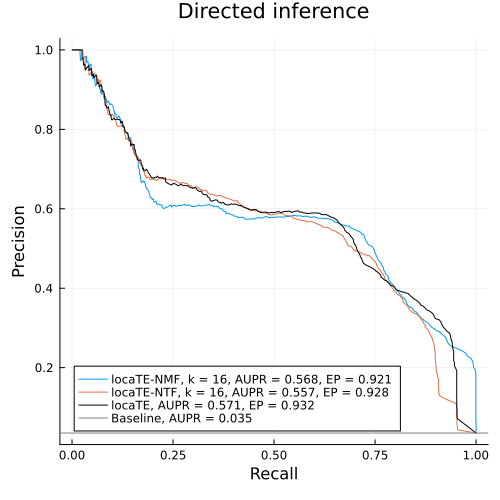

In [110]:
# AUPR
plt=plot(; title="Directed inference", size = (PLT_CELL, PLT_CELL), xlabel = "Recall", ylabel = "Precision", legend = :bottomleft)
# locaTE-NMF
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G_nmf, Nq)))
plot!(r, p; label = @sprintf("locaTE-NMF, k = 16, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)))
# locaTE-NTF
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G_ntf, Nq)))
plot!(r, p; label = @sprintf("locaTE-NTF, k = 16, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)))
# locaTE
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G, Nq)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :black)
# baseline 
baseline = mean((R * reshape(abs.(J), :, size(X, 2)^2)) .> 0.5)
hline!([baseline, ]; label = @sprintf("Baseline, AUPR = %0.3f", baseline), color = :grey)
savefig(string(FIG_DIR, "switch_sim_nmf_aupr.pdf"))
plt